In [1]:
import lightkurve as lk
from lightkurve import search_targetpixelfile

In [2]:
import matplotlib.pyplot as plt
import astropy.units as units
import numpy as np

In [3]:
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import corner

In [4]:
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares

In [5]:
import arviz as az

In [6]:
import aesara_theano_fallback.tensor as tt

from celerite2.theano import terms, GaussianProcess

## Download the lightcurve and normalize

In [7]:
search_result = lk.search_lightcurve("TIC 147977348", author="SPOC")
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 33,2020,SPOC,120,147977348,0.0
1,TESS Sector 34,2021,SPOC,120,147977348,0.0


In [8]:
#download
lc_file = search_result.download_all(quality_bitmask="hardest", flux_column="pdcsap_flux")
lc_stitched= lc_file.stitch()

#normalize flux and remove outliers! 
lc = lc_stitched.remove_nans().normalize().remove_outliers()

#save time and flux 
time = lc.time.value
flux = lc.flux

In [9]:
# For the purposes of this example, we'll discard some of the data
# m = (lc.quality == 0) & (np.random.default_rng(261136679).uniform(size=len(time)) < 0.3)
#m = (lc.quality == 0)
# m = np.ones_like(time)

In [10]:
#calculate total exposure time (frame time * num_frames)
with fits.open(lc_stitched.filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

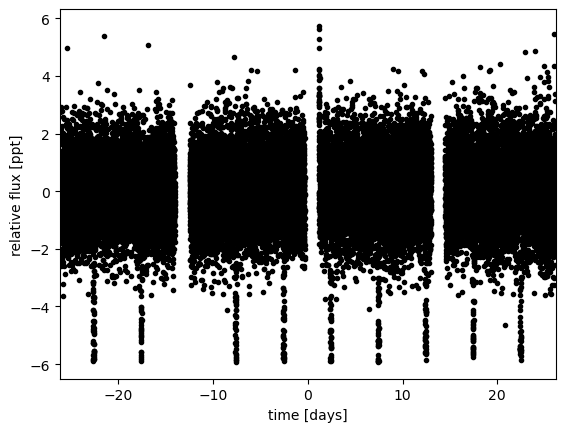

In [11]:
#set the middle time to 0 
ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time - ref_time, dtype=np.float64)

#change flux scale so we can see it and make the average normalized flux 0  
y = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64)

plt.plot(x, y, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())
plt.show()
plt.close()

## Estimate period, phase, and depth 

In [12]:
# period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

# bls = BoxLeastSquares(x, y)
# bls_power = bls.power(period_grid, 0.1, oversample=20)

# # Save the highest peak as the planet candidate
# index = np.argmax(bls_power.power)

# bls_period = bls_power.period[index]
# bls_t0 = bls_power.transit_time[index]
# bls_depth = bls_power.depth[index]
# bls_dur = bls_power.duration[index]

# transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

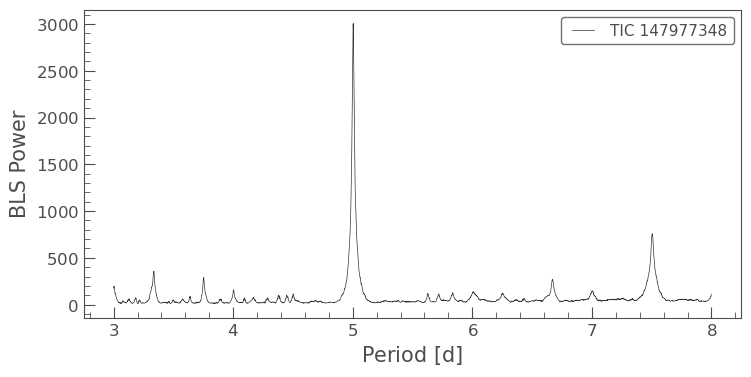

In [13]:
# Create array of periods to search
period = np.linspace(3, 8, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();
plt.show()
plt.close()


In [14]:
bls_period = bls.period_at_max_power
bls_t0 = bls.transit_time_at_max_power
bls_dur = bls.duration_at_max_power
bls_depth = bls.depth_at_max_power

bls_t0

<Time object: scale='tdb' format='btjd' value=2205.3005908207974>

In [15]:
bls_model = bls.get_transit_model(period=bls_period,
                                       transit_time=bls_t0,
                                       duration=bls_dur)

In [16]:
1e3*bls_depth.value -1

3.915352489337482

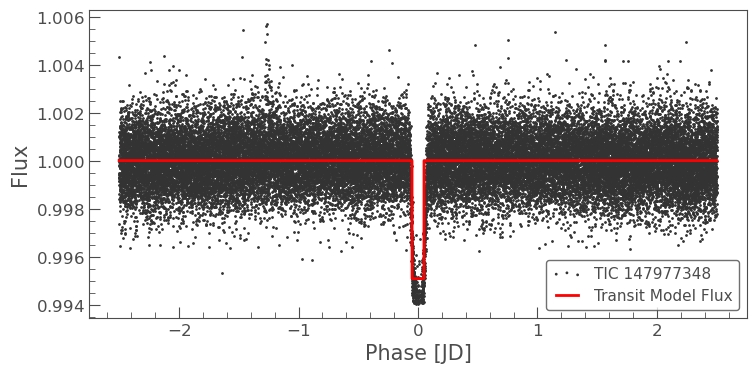

In [17]:
fold_lc = lc.fold(bls_period, bls_t0)
ax = fold_lc.scatter();
bls_model.fold(bls_period, bls_t0).plot(ax=ax, c='r', lw=2)
#ax.set_xlim(-2.5, 2.5);
plt.show()
plt.close()

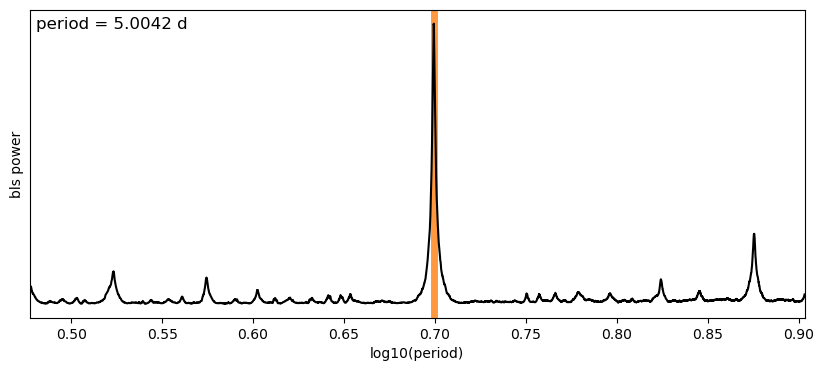

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(10, 4))

# Plot the periodogram
ax = axes
ax.axvline(np.log10(bls_period.value), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls.period.value), bls.power.value, "k")
ax.annotate(
    "period = {0:.4f}".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period.min()), np.log10(period.max()))
ax.set_xlabel("log10(period)")

plt.show()


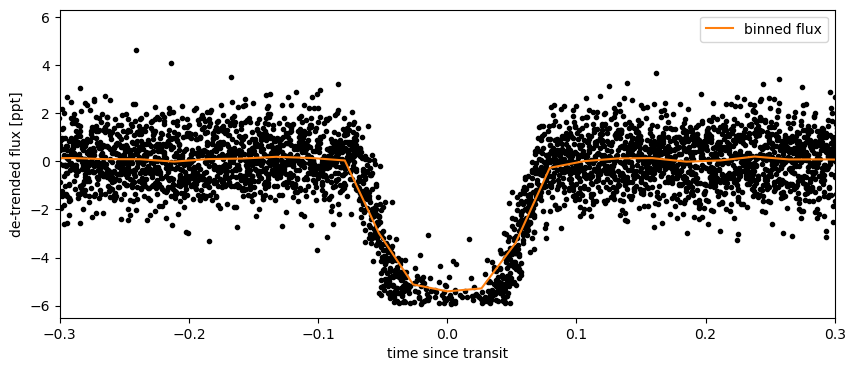

In [19]:
# Plot the folded transit
fig, axes = plt.subplots(1, 1, figsize=(10, 4))
ax = axes

x = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64)

x_fold = (x - (bls_t0.value - ref_time) + 0.5 * bls_period.value) % bls_period.value - 0.5 * bls_period.value
m = np.abs(x_fold) < 0.4
ax.plot(x_fold, y, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1", label='binned flux')

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")
plt.legend()
plt.show()
plt.close()

# Create Model 

In [20]:
x = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64)

In [21]:
1e3 * bls_depth.value - 1.0

3.915352489337482

In [22]:
phase_lc = np.linspace(-0.3, 0.3, 100)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

#         # Stellar parameters from Huang et al (2018)
#         M_star_huang = 1.094, 0.039
#         R_star_huang = 1.10, 0.023
        #Stellar parameters from Rodriguez et al 2021
        M_star_huang = 1.526, 0.072
        R_star_huang = 2.082, 0.058
        
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_huang[0], sd=M_star_huang[1])
        r_star = BoundedNormal("r_star", mu=R_star_huang[0], sd=R_star_huang[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=(bls_t0.value - ref_time), sd=1)
        
        log_period = pm.Normal("log_period", mu=np.log(bls_period.value), sd=1)
        period = pm.Deterministic("period", tt.exp(log_period))

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(1e3 * bls_depth.value - 1.0), sigma=2.0)
        ror = pm.Deterministic("ror", star.get_ror_from_approx_transit_depth(1e-3 * tt.exp(log_depth), b),)
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        #         log_r_pl = pm.Normal(
        #             "log_r_pl",
        #             sd=1.0,
        #             mu=0.5 * np.log(1e-3 * np.array(bls_depth))
        #             + np.log(R_star_huang[0]),
        #         )
        #         r_pl = pm.Deterministic("r_pl", tt.exp(log_r_pl))
        #         ror = pm.Deterministic("ror", r_pl / r_star)
        #         b = xo.distributions.ImpactParameter("b", ror=ror)

        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
            * 1e3)
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -51762.0127910184 -> -51207.67367153956
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -51207.67367153956 -> -51169.84937722157
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -51169.84937722157 -> -50982.31897658869
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -50982.31897658869 -> -50973.50375789296
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -50973.50375789296 -> -50959.60205306989
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -50959.60205306989 -> -50932.04077908441
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -50932.04077908441 -> -50926.00945236976
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -50926.00945236976 -> -50925.12908149808
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -50925.12908149808 -> -50915.342619328105
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: -50915.342619328105 -> -50890.21505372583
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -50890.21505372583 -> -50810.236414553525


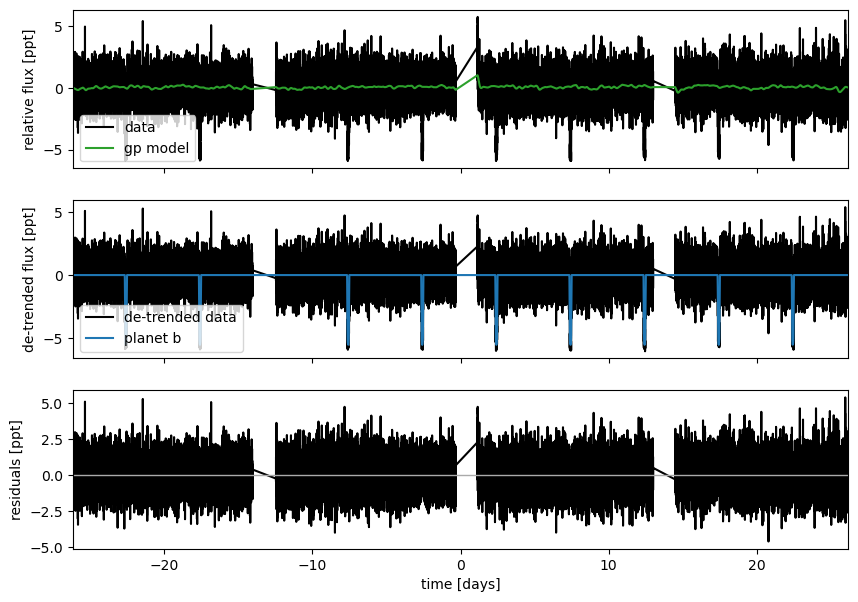

In [23]:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = extras["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


_ = plot_light_curve(map_soln0, extras0)
plt.show()

# Delete outliers

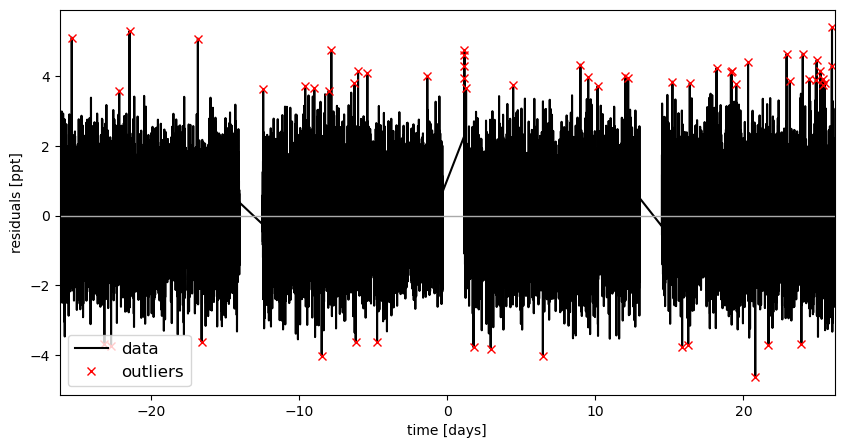

In [24]:
mod = (
    extras0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(extras0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())
plt.show()

# Redo Make Model without outliers

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -50335.4151816864 -> -50325.08112502916
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -50325.08112502916 -> -50325.01347626328
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: -50325.01347626328 -> -50325.00614312539
optimizing logp for variables: [t0, log_period]


message: Optimization terminated successfully.
logp: -50325.00614312539 -> -50324.96121258036
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -50324.96121258036 -> -50324.95816421285
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -50324.95816421285 -> -50324.9578338281
optimizing logp for variables: [b]


message: Desired error not necessarily achieved due to precision loss.
logp: -50324.9578338281 -> -50324.956183090864
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -50324.956183090864 -> -50324.955960868545
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -50324.955960868545 -> -50324.91454049898
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: -50324.91454049898 -> -50324.91445821468
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -50324.91445821467 -> -50324.90955251672


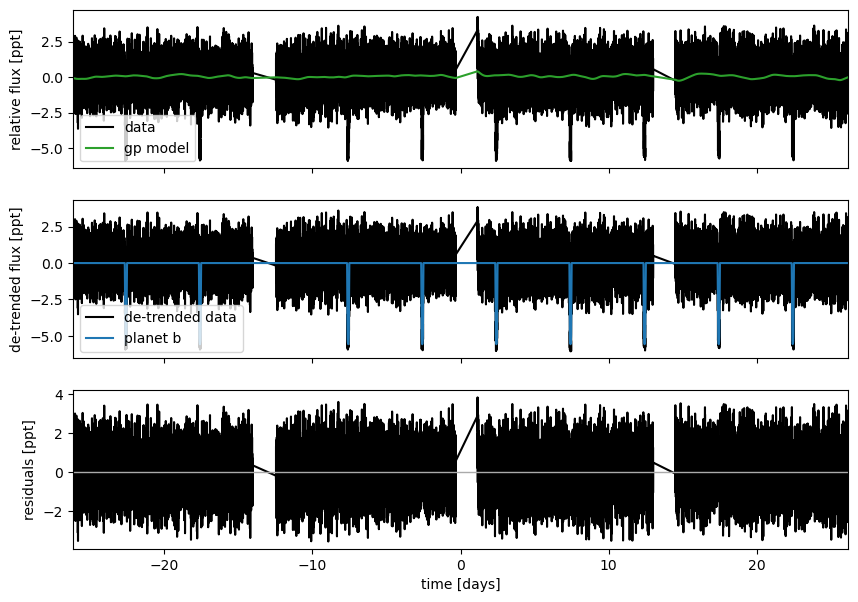

In [25]:
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)
plt.show()

# SAMPLING!

In [ ]:
with model:
    trace = pm.sample(
        tune=1500,
        draws=1000,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=1,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[261136679, 261136680],
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/katyaleidig/Library/Python/3.7/lib/python/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


In [ ]:
az.summary(
    trace,
    var_names=[
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "period",
        "r_star",
        "m_star",
        "u_star",
        "mean",
    ],
)


In [ ]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
gp_mod = extras["gp_pred"] + map_soln["mean"]  # np.median(
#     flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
# )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(
    0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned"
)

# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc, pred[1], color="C1", label="model")
art = plt.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values)
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
_ = plt.xlim(-0.15, 0.15)
plt.show()

In [ ]:
trace.posterior["r_earth"] = (
    trace.posterior["r_pl"].coords,
    (trace.posterior["r_pl"].values * units.R_sun).to(units.R_earth).value,
)

_ = corner.corner(
    trace,
    var_names=["period", "r_earth", "b", "ecc"],
    labels=[
        "period [days]",
        "radius [Earth radii]",
        "impact param",
        "eccentricity",
    ],
)
plt.show()